### Create trajectory plots for all saved models for presentation

In [1]:
%env CUDA_VISIBLE_DEVICES = ''
%load_ext autoreload
%autoreload 2
import torch
import numpy
from mapsgan.evaluation import Visualization
import mapsgan.experiments as experiments
from mapsgan import data_loader
from mapsgan.solver import BaseSolver, Solver, SGANSolver
from mapsgan.toymodules import ToyGenerator, ToyDiscriminator, BicycleGenerator
from sgan import TrajectoryGenerator, TrajectoryDiscriminator
import glob
import matplotlib.pyplot as plt

env: CUDA_VISIBLE_DEVICES=''


In [2]:
model_name_list = ['toymodel', 'clr', 'cvae', 'bicy', 'sgan'] # PUT SGAN LAST BECAUSE IT CHANGES STUFF
models_folder = '../models/presentation/'

In [3]:
experiment = experiments.ETH() # we store filepaths and arguments in here
_ , testloader = data_loader(in_len=8, out_len=12, batch_size=64, num_workers=1, path=experiment.test_dir,
                                  shuffle=True)

In [9]:
generator = ToyGenerator(in_len=8, out_len=8)
discriminator = ToyDiscriminator()
solver = BaseSolver(generator, discriminator)

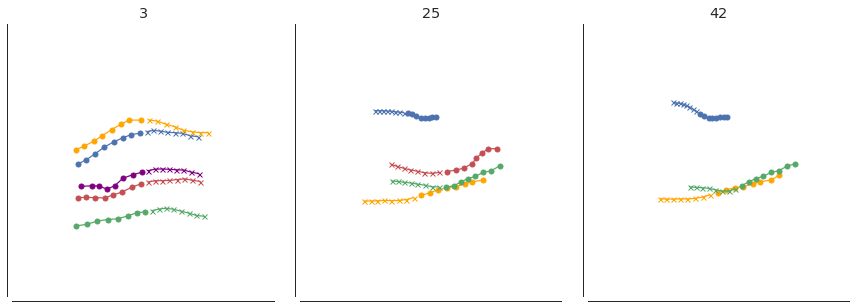

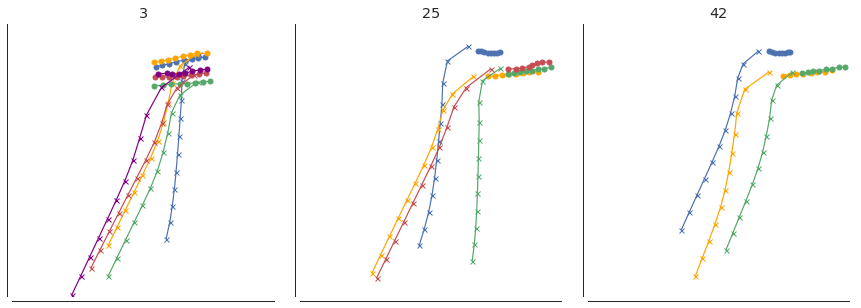

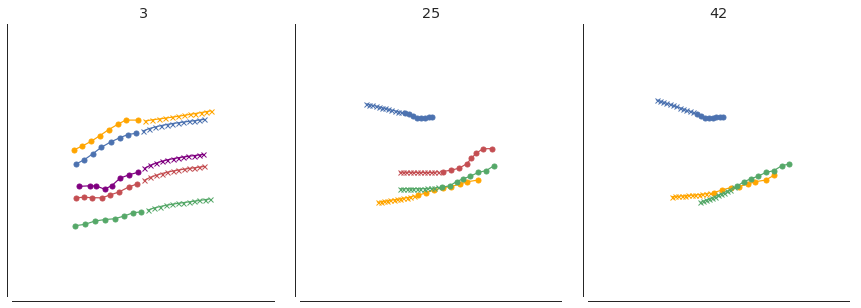

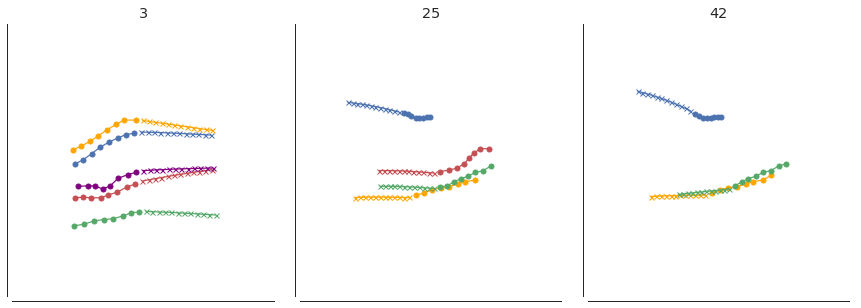

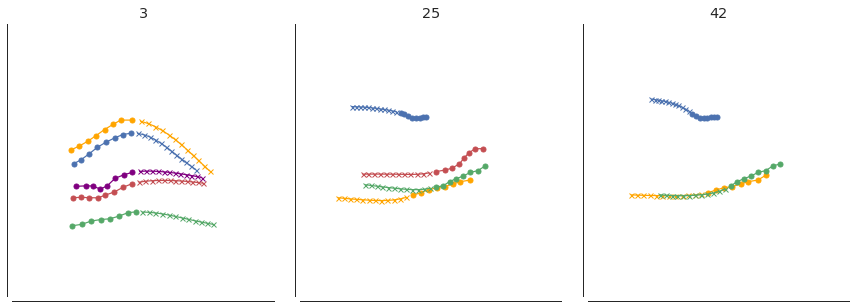

In [10]:
vis = Visualization()
for model_name in model_name_list:
    if model_name == 'toymodel':
        generator = ToyGenerator(in_len=8, out_len=8)
        discriminator = ToyDiscriminator()
    elif model_name == 'clr':
        solver.generator = BicycleGenerator(generator=ToyGenerator, start_mode='clr')
    elif model_name == 'cvae':
        solver.generator = BicycleGenerator(generator=ToyGenerator, start_mode='cvae')
    elif model_name == 'bicy':
        solver.generator = BicycleGenerator(generator=ToyGenerator, start_mode='cvae')
    elif model_name == 'sgan':
        
        generator = TrajectoryGenerator(obs_len=8,
                                                pred_len=12,
                                                embedding_dim=16,
                                                encoder_h_dim=32,
                                                decoder_h_dim=32,
                                                mlp_dim=64,
                                                num_layers=1,
                                                noise_dim=(8,),
                                                noise_type='gaussian',
                                                noise_mix_type='global',
                                                pooling_type='pool_net',
                                                pool_every_timestep=1,
                                                dropout=0,
                                                bottleneck_dim=32,
                                                neighborhood_size=2,
                                                grid_size=8,
                                                batch_norm=0)

        discriminator = TrajectoryDiscriminator(obs_len=8,
                                                        pred_len=12,
                                                        embedding_dim=16,
                                                        h_dim=64,
                                                        mlp_dim=64,
                                                        num_layers=1,
                                                        dropout=0,
                                                        batch_norm=0,
                                                        d_type='local')
        solver = SGANSolver(generator, discriminator, experiment=experiment)
    else:
        print('Model name not known. ' + model_name)
        continue
        
    model_folder = models_folder + model_name + '_*'
    filelist = glob.glob(model_folder)
    filename = filelist[0]
    
    output = solver.test(testloader, load_checkpoint_from=filename) 
    vis.trajectories(output, scenes=[3, 25, 42])
    
    savefigname = models_folder + model_name + '.png'
    plt.savefig(savefigname)
    plt.show()
   

### The gt

In [14]:
import numpy as np

def init_subplot(self, title,
                 tot_tup=(1, 1), sp_tup=(0, 0),
                 colspan=1, rowspan=1,
                 sharex=None, sharey=None,
                 xlabel='', ylabel='',
                 despine=True,
                 offset=5, trim=False,
                 ttl_fs=15, ttl_pos='center'):

    ax = plt.subplot2grid(tot_tup, sp_tup, colspan, rowspan, sharex=sharex, sharey=sharey)
    ax.set_title(title, fontsize=ttl_fs, loc=ttl_pos)

    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)

    sns.set(context='paper', style='ticks', font_scale=1.5)
    sns.axes_style({'axes.edgecolor': '.6', 'axes.linewidth': 5.0})
    if despine is True:
        sns.despine(ax=ax, offset=offset, trim=trim)

    return ax

def init_figure(self, figsize, hspace=.3, wspace=.1):
    fig = plt.figure(figsize=figsize)
    plt.subplots_adjust(hspace=hspace, wspace=wspace)
    return fig

In [16]:
import seaborn as sns

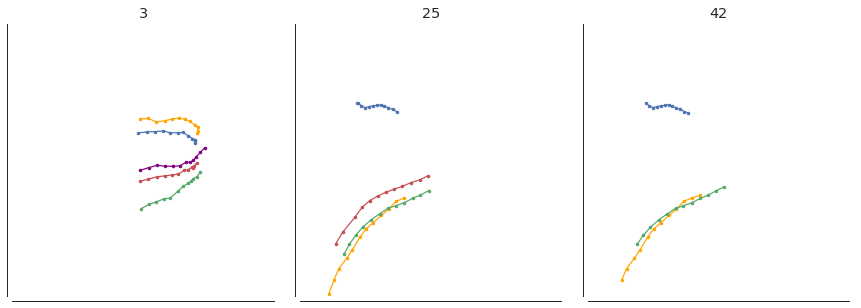

In [18]:

class PlotProps:
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

    def __init__(self):
        pass

    # Set figure and subplot properties

    def init_figure(self, figsize, hspace=.3, wspace=.1):
        fig = plt.figure(figsize=figsize)
        plt.subplots_adjust(hspace=hspace, wspace=wspace)
        return fig

    def init_subplot(self, title,
                     tot_tup=(1, 1), sp_tup=(0, 0),
                     colspan=1, rowspan=1,
                     sharex=None, sharey=None,
                     xlabel='', ylabel='',
                     despine=True,
                     offset=5, trim=False,
                     ttl_fs=15, ttl_pos='center'):

        ax = plt.subplot2grid(tot_tup, sp_tup, colspan, rowspan, sharex=sharex, sharey=sharey)
        ax.set_title(title, fontsize=ttl_fs, loc=ttl_pos)

        plt.xlabel(xlabel, fontsize=15)
        plt.ylabel(ylabel, fontsize=15)

        sns.set(context='paper', style='ticks', font_scale=1.5)
        sns.axes_style({'axes.edgecolor': '.6', 'axes.linewidth': 5.0})
        if despine is True:
            sns.despine(ax=ax, offset=offset, trim=trim)

        return ax

    def legend(self, loc='best', fontsize=15):
        plt.legend(loc=loc, fontsize=fontsize, frameon=False)


plot = PlotProps()

scenes = [3, 25, 42]
scenes_list = scenes
num_scenes = len(scenes)

gridwidth = int(np.ceil(np.sqrt(num_scenes)))+1
gridheight = gridwidth if gridwidth * (gridwidth - 1) < num_scenes else (gridwidth -1)-1
figsize = [5*gridwidth, 5*gridheight]

ymin = np.min([np.min(seq[:, :, 1]) for scene in output.values() for seq in scene]) - 0.1
ymax = np.max([np.max(seq[:, :, 1]) for scene in output.values() for seq in scene]) + 0.1
xmin = np.min([np.min(seq[:, :, 0]) for scene in output.values() for seq in scene]) - 0.1
xmax = np.max([np.max(seq[:, :, 0]) for scene in output.values() for seq in scene]) + 0.1

fig = plot.init_figure(figsize)
max_a = 0
for i, s in enumerate(scenes_list):
    num_agents = output['xy_in'][s].shape[1]
    max_a = max(max_a,num_agents)

    color = ['b', 'orange', 'g', 'r', 'purple', 'k']
    ax = plot.init_subplot(type, tot_tup=(gridheight, gridwidth), sp_tup=(int(i // gridwidth), int(i % gridwidth)))
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.set_xticks([])
    ax.set_yticks([])

    for a in range(num_agents):
        ax.plot( output['xy_out'][s][:, a, 0], output['xy_out'][s][:, a, 1],
                 '.-', c=color[a%len(color)], markersize=5, label=f'Output Agent {a}')

    ax.set_title(s)
    
savefigname = models_folder + 'gt' + '.png'
plt.savefig(savefigname)
plt.show()
    